# **0. 패키지 로딩**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
np.set_printoptions(suppress = True)

# **1. 데이터 불러오기**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- 현재 매장은 `type`에 따라 5개로 구분되어있는 상태
  - typeA, typeB, typeC, typeD, typeE
  


In [4]:
## 파일 상위 경로 설정
# 본인 경로에 맞게 수정 필요(작업하는 곳에 공유 드라이브 바로가기 해두면 편함)

train_path = '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train'
val_path = '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val'
test_path = '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/test'

In [5]:
# 데이터 파일 경로 저장
train_files = [os.path.join(train_path, f'train{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]
val_files = [os.path.join(val_path, f'val{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]
test_files = [os.path.join(test_path, f'test{i}.csv') for i in ['A', 'B', 'C', 'D', 'E']]

# 각 파일을 데이터프레임 형태로 불러오기
train_types = [pd.read_csv(file) for file in train_files]
val_types = [pd.read_csv(file) for file in val_files]
test_types = [pd.read_csv(file) for file in test_files]

In [6]:
### 데이터 확인

print(train_files)
print(val_files)
print(test_files)

['/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainA.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainB.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainC.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainD.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/train/trainE.csv']
['/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valA.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valB.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valC.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valD.csv', '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/data/modeling/val/valE.csv']
['/content/drive/MyDrive/ESAA 8기/OB/winter_proj

- 파일이 제대로 로드되었다.

# **2. 평가 지표**
- Root Mean Squared Logarithmic Error(`RMSLE`)
  - 다음과 같이 계산  
  $ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $
  - $n$: 총 인스턴스 수
  - $ \hat{y}_i$: 인스턴스 $i$에 대한 타겟의 예측값
  - $y_i$: 인스턴스 $i$에 대한 타겟의 실제값

In [7]:
from sklearn.metrics import mean_squared_log_error

### RMSLE 계산
def rmsle(y, pred):
    # 오버플로, 언더플로 방지를 위해 log1p()로 로그 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)

    squared_error = (log_y - log_pred) ** 2

    rmsle = np.sqrt(np.mean(squared_error))

    return rmsle

# **3. 모델별 성능 확인을 위한 함수**

In [8]:
colors = [
    'khaki', 'teal', 'orchid', 'sandybrown', 'greenyellow', 'dodgerblue', 'rosybrown',
    'deeppink', 'salmon', 'olivedrab', 'olive', 'forestgreen',
    'royalblue', 'mediumpurple', 'gold', 'seagreen',
    'turquoise', 'steelblue', 'slategray', 'peru', 'slateblue', 'cadetblue',
    'lime', 'lavender', 'lightcoral', 'lightseagreen', 'lightskyblue', 'lightgreen',
    'lightpink', 'lightsalmon', 'lightsteelblue', 'lightyellow', 'palegreen',
]

In [9]:
## 회귀곡선 시각화
# 예측값, 실제값을 산점도로 표현

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': actual})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='b')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

In [10]:
def model_eval(name_, pred, actual):
    global my_predictions
    global colors

    plot_predictions(name_, pred, actual)

    rmsle = np.sqrt(mean_squared_log_error(actual, pred))

    my_predictions[name_] = {'rmsle': rmsle}

    # 데이터프레임 생성
    df = pd.DataFrame(my_predictions).T
    df['model'] = df.index
    df = df.sort_values(by=['rmsle'], ascending=[True])

    # 상한, 하한 설정
    min_ = df['rmsle'].min() - 0.1
    max_ = df['rmsle'].max() + 0.1

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['rmsle'])

    for i, v in enumerate(df['rmsle']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 0.02, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('RMSLE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

    print()
    print(df)

In [11]:
# 모델의 중요도 상위 10개의 피처명과 그때의 중요도 값을 Series로 반환

def get_top_features(model, df):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index = df.columns)
    ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]
    return ftr_top10

def visualize_ftr_importances(model, df):
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.tight_layout()

    ftr_top10 = get_top_features(model, df)
    ax.set_title(model.__class__.__name__ + ' Feature Importances', size=15)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

    sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax, palette = 'Set1')

# **4. 모델링**

## **🏪 Type A**

In [12]:
trainA = train_types[0]
valA = val_types[0]
testA = test_types[0]

In [13]:
trainA.head()

,sales,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,9.104758,3.355491,-1.025047,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,5.723585,-0.544403,1.190046,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,7.003974,-0.544403,1.588964,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,7.289877,3.004131,-0.881090,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,8.633909,-0.544403,1.728982,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
trainA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250486 entries, 0 to 250485
Data columns (total 84 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   sales                              250486 non-null  float64
 1   onpromotion                        250486 non-null  float64
 2   dcoilwtico                         250486 non-null  float64
 3   store_nbr_44                       250486 non-null  int64  
 4   store_nbr_45                       250486 non-null  int64  
 5   store_nbr_46                       250486 non-null  int64  
 6   store_nbr_47                       250486 non-null  int64  
 7   store_nbr_48                       250486 non-null  int64  
 8   store_nbr_49                       250486 non-null  int64  
 9   store_nbr_50                       250486 non-null  int64  
 10  store_nbr_51                       250486 non-null  int64  
 11  store_nbr_52                       2504

In [15]:
valA.head()

,sales,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,27.000,0.105579,-0.468095,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,617.000,1.405544,-0.899535,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,255.081,0.755561,-0.496725,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,597.000,2.705508,-0.689414,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,201.000,-0.544403,-0.769613,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
testA.head()

,id,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,...,month_5,month_6,month_7,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_4
0,3002142,-0.544403,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3002143,-0.544403,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3002144,0.485794,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3002145,2.435741,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3002146,-0.544403,-0.723098,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**데이터 준비**

In [17]:
## Feature vs Target

X_trainA = trainA.drop('sales', axis=1)
y_trainA = trainA['sales']

X_valA = valA.drop('sales', axis=1)
y_valA = valA['sales']

In [18]:
print(X_trainA.shape, y_trainA.shape)
print(X_valA.shape, y_valA.shape)

(250486, 83) (250486,)
(107352, 83) (107352,)


In [19]:
X_testA = testA.drop(['id', 'family_BABY CARE'], axis = 1) # train 데이터에는 해당 정보가 x

In [20]:
X_testA = X_testA[X_trainA.columns] # 피처 순서 재조정

In [21]:
X_testA.shape

(4752, 83)

### **4-1. Base Model**

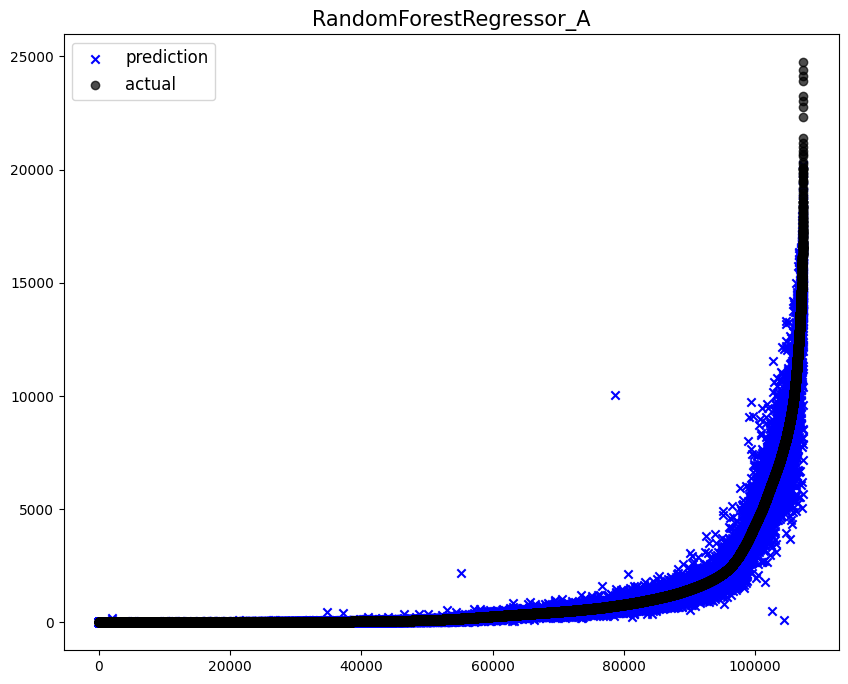

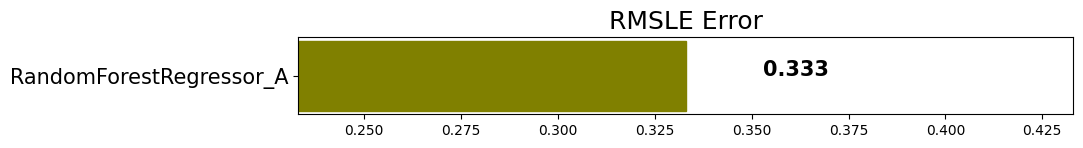


                            rmsle                    model
RandomForestRegressor_A  0.332977  RandomForestRegressor_A


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseA = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseA.fit(X_trainA, y_trainA)

# 모델 예측
rf_predA = rf_baseA.predict(X_valA)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predA = np.expm1(rf_predA)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_A', original_rf_predA, y_valA)

### **4-2. 하이퍼 파라미터 튜닝**


#### **HyperOpt**
- 베이지안 최적화 알고리즘을 활용하여 효율적인 하이퍼파라미터 최적화를 제공하는 파이썬 라이브러리
  - 이를 통해 사용자는 자동화된 최적화, 다양한 최적화 알고리즘 선택, 고급 최적화 알고리즘 활용 등을 통해 모델 성능을 향상시킬 수 있음
- **주요 로직**
  1. 입력 변수명과 입력값의 검색 공간 설정
  2. 목적 함수 설정
  3. 목적 함수의 반환 최솟값을 가지는 최적 입력값 유추
- 참고자료  
  [베이지안 최적화에 기반한 HyperOpt를 활용한 하이퍼 파라미터 튜닝](https://teddylee777.github.io/machine-learning/hyper-opt/)

In [ ]:
# !pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [ ]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)), # 트리 개수
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]), # 트리의 최대 깊이
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)), # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)), # 리프 노드를 위한 최소 샘플 수
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']) # 트리 분할 시 사용할 최대 특성의 수
}

In [ ]:
## 목적 함수 설정

def objective(params):
  model = RandomForestRegressor(**params)
  model.fit(X_trainA, y_trainA)

  y_pred = model.predict(X_valA)
  y_pred = np.expm1(y_pred) # 원래 스케일로 원복

  rmsle_val = rmsle(y_valA, y_pred)

  return {'loss': rmsle_val, 'status': STATUS_OK}

In [ ]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 30,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|██████████| 30/30 [2:00:31<00:00, 241.04s/trial, best loss: 0.32304888052749414]
{'max_depth': 0, 'max_features': 0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 130}


- 하이퍼 파라미터 튜닝을 진행한 **model**의 성능이 더 좋다.

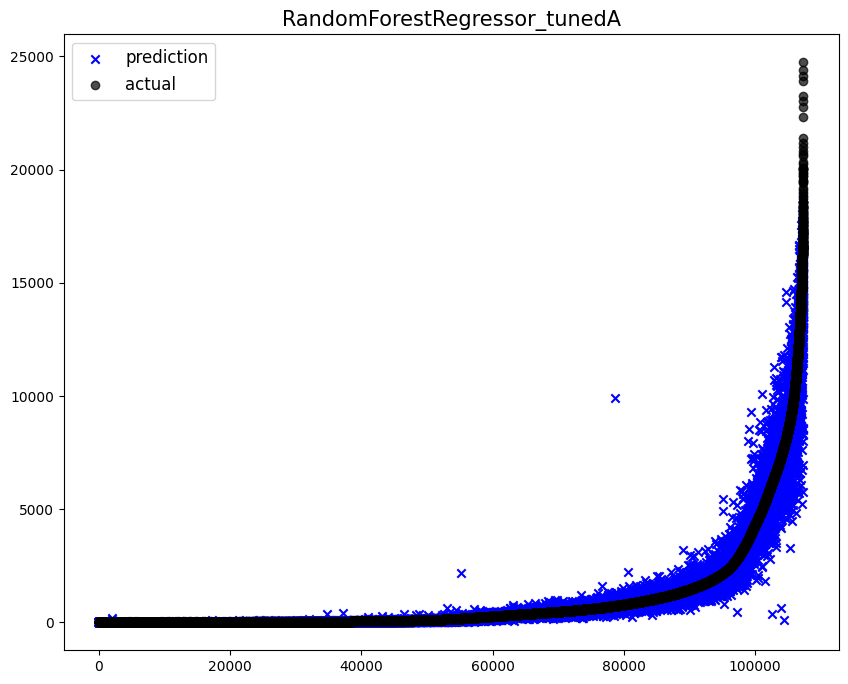

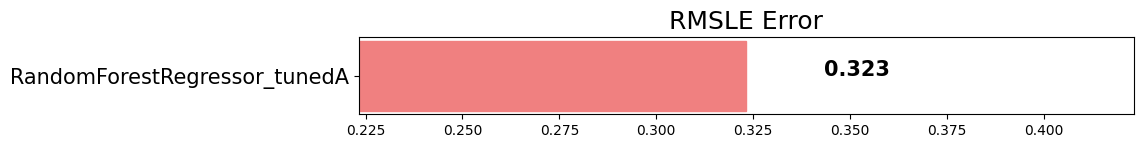


                                 rmsle                         model
RandomForestRegressor_tunedA  0.323226  RandomForestRegressor_tunedA


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedA = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 4,
                                  min_samples_split = 2, n_estimators = 130,
                                  n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedA.fit(X_trainA, y_trainA)

# 모델 예측
rf_predA = rf_tunedA.predict(X_valA)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predA = np.expm1(rf_predA)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedA', original_rf_predA, y_valA)

<ipython-input-11-33f300f93aba>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax, palette = 'Set1')


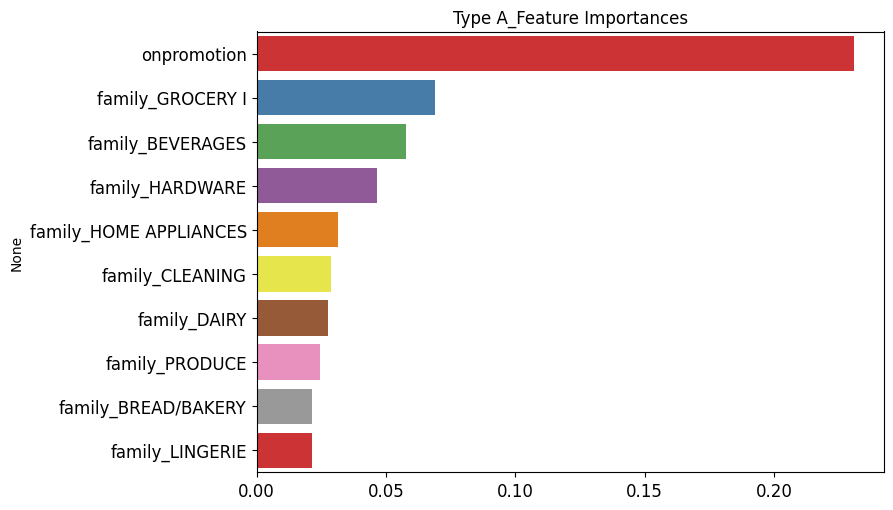

In [ ]:
visualize_ftr_importances(rf_tunedA, X_trainA)
plt.title("Type A_Feature Importances")
plt.show()

- `onpromotion`이 매출에 큰 영향을 미침
- 제품군의 종류 또한 모델의 예측 성능에 큰 영향을 미침

In [ ]:
### 모델 저장

import pickle
import joblib

joblib.dump(rf_tunedA, '/content/drive/MyDrive/Colab Notebooks/ESAA 학회_OB/esaa OB 3조/방학프로젝트/model/modelA_final.pkl')

### **4-3. 최종 예측**

#### **모델 불러오기**

In [22]:
import joblib

modelA = joblib.load('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/model/modelA_final.pkl')

#### **예측 수행**

In [23]:
predA = modelA.predict(X_testA)
predA = np.expm1(predA)
predA = np.round(predA, 2) # 소수 둘째자리에서 반올림

In [24]:
submissionA = pd.DataFrame({'id': testA['id'],
                      'sales': predA})
submissionA

,id,sales
0,3002142,15.66
1,3002143,126.70
2,3002144,16.78
3,3002145,8744.23
4,3002146,1.83
...,...,...
4747,3029197,355.53
4748,3029198,100.83
4749,3029199,3754.37
4750,3029200,3.71


#### **판매하지 않는 제품군 처리**
- 매출을 모두 0으로 처리

**전체**

In [25]:
zero_id_A = testA.loc[testA['family_BABY CARE'] == 1, 'id']
submissionA.loc[submissionA['id'].isin(zero_id_A), 'sales'] = 0

In [26]:
submissionA

,id,sales
0,3002142,15.66
1,3002143,0.00
2,3002144,16.78
3,3002145,8744.23
4,3002146,1.83
...,...,...
4747,3029197,355.53
4748,3029198,100.83
4749,3029199,3754.37
4750,3029200,3.71


**store별**
- 44, 45, 46, 47, 48, 49, 50, 51: BABY CARE
- 52: BABY CARE, BOOKS

In [27]:
zero_id_52 = testA.loc[(testA['store_nbr_52'] == 1)&(testA['family_BOOKS'] == 1), 'id']
submissionA.loc[submissionA['id'].isin(zero_id_52), 'sales'] = 0

#### **순서 정렬**

In [28]:
submissionA = submissionA.sort_values(by='id')
submissionA

,id,sales
0,3002142,15.66
1,3002143,0.00
2,3002144,16.78
3,3002145,8744.23
4,3002146,1.83
...,...,...
4747,3029197,355.53
4748,3029198,100.83
4749,3029199,3754.37
4750,3029200,3.71


## **🏪 Type B**

In [29]:
trainB = train_types[1]
valB = val_types[1]
testB = test_types[1]

In [30]:
trainB.head()

,sales,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,8.655214,-0.522014,-0.084655,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.225747,0.112980,1.514441,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,5.143831,3.024402,1.771311,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2.484907,-0.522014,-0.875071,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,2.282382,-0.522014,1.641002,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
trainB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205795 entries, 0 to 205794
Data columns (total 85 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   sales                              205795 non-null  float64
 1   onpromotion                        205795 non-null  float64
 2   dcoilwtico                         205795 non-null  float64
 3   store_nbr_9                        205795 non-null  int64  
 4   store_nbr_11                       205795 non-null  int64  
 5   store_nbr_18                       205795 non-null  int64  
 6   store_nbr_20                       205795 non-null  int64  
 7   store_nbr_21                       205795 non-null  int64  
 8   store_nbr_31                       205795 non-null  int64  
 9   store_nbr_34                       205795 non-null  int64  
 10  store_nbr_39                       205795 non-null  int64  
 11  family_AUTOMOTIVE                  2057

In [32]:
valB.head()

,sales,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,4.000,-0.522014,-0.853169,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,305.289,1.587390,-0.544259,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,517.000,-0.522014,1.319604,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.000,-0.522014,-1.218259,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,4.000,-0.522014,-0.880229,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [33]:
testB.head()

,id,onpromotion,dcoilwtico,store_nbr_9,store_nbr_11,store_nbr_18,store_nbr_20,store_nbr_21,store_nbr_31,store_nbr_34,...,month_5,month_6,month_7,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_4
0,3000954,-0.522014,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3000955,-0.522014,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3000956,0.484427,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3000957,3.115180,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000958,-0.522014,-0.620862,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**데이터 준비**

In [34]:
## Feature vs Target

X_trainB = trainB.drop('sales', axis=1)
y_trainB = trainB['sales']

X_valB = valB.drop('sales', axis=1)
y_valB = valB['sales']

In [35]:
print(X_trainB.shape, y_trainB.shape)
print(X_valB.shape, y_valB.shape)

(205795, 84) (205795,)
(88198, 84) (88198,)


In [36]:
X_testB = testB.drop(['id', 'family_BOOKS'], axis = 1) # train(Type B) 데이터에는 해당 정보가 x

In [37]:
X_testB = X_testB[X_trainB.columns] # 피처 순서 재조정

In [38]:
X_testB.shape

(4224, 84)

### **4-1. Base Model**

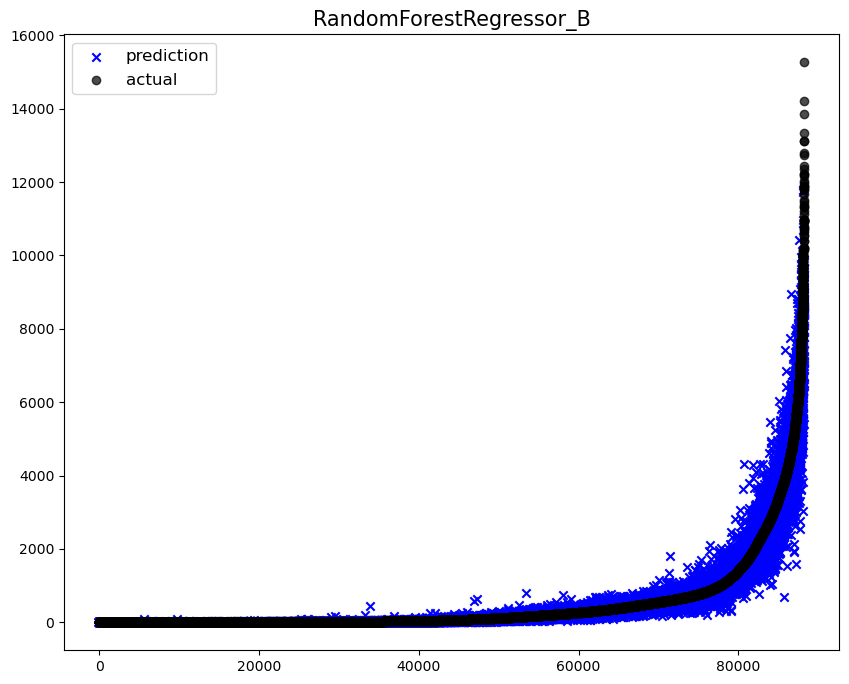

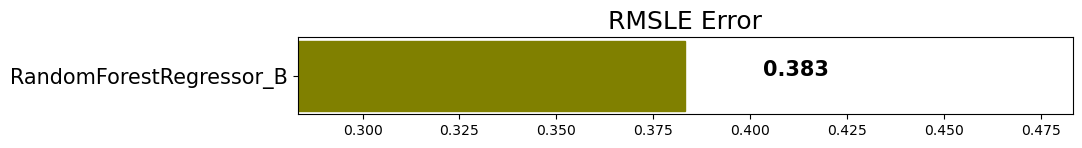


                            rmsle                    model
RandomForestRegressor_B  0.383234  RandomForestRegressor_B


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseB = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseB.fit(X_trainB, y_trainB)

# 모델 예측
rf_predB = rf_baseB.predict(X_valB)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predB = np.expm1(rf_predB)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_B', original_rf_predB, y_valB)

### **4-2. 하이퍼 파라미터 튜닝**


In [ ]:
# !pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [ ]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)), # 트리 개수
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]), # 트리의 최대 깊이
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)), # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)), # 리프 노드를 위한 최소 샘플 수
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']) # 트리 분할 시 사용할 최대 특성의 수
}

In [ ]:
## 목적 함수 설정

def objective(params):
    model = RandomForestRegressor(**params)
    model.fit(X_trainB, y_trainB)

    y_pred = model.predict(X_valB)
    y_pred = np.expm1(y_pred) # 원래 스케일로 원복

    rmsle_val = rmsle(y_valB, y_pred)

    return {'loss': rmsle_val, 'status': STATUS_OK}

In [ ]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 30,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|███████████████████████████████████████████████| 30/30 [58:00<00:00, 116.03s/trial, best loss: 0.3704980435650204]
{'max_depth': 0, 'max_features': 0, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 143}


- 하이퍼 파라미터 튜닝을 진행한 **model**의 성능이 더 좋다.

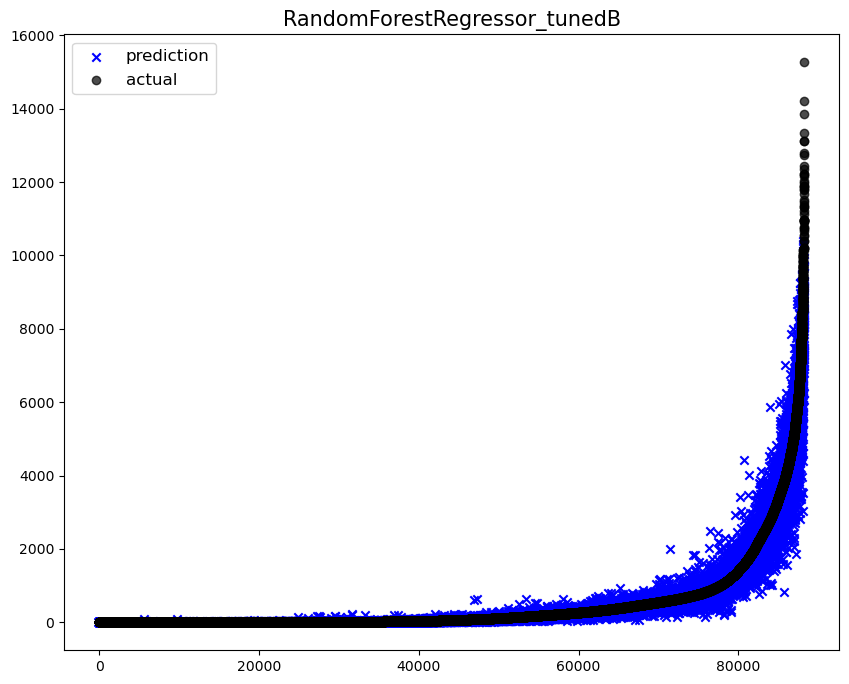

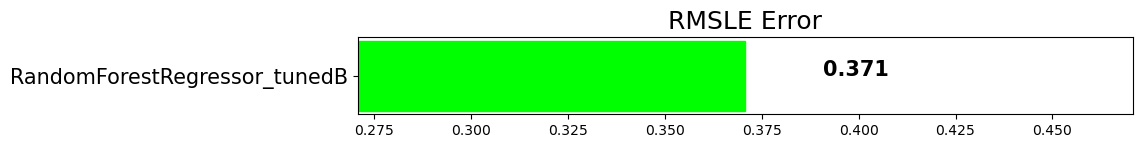


                                 rmsle                         model
RandomForestRegressor_tunedB  0.370754  RandomForestRegressor_tunedB


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedB = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 6,
                                  min_samples_split = 6, n_estimators = 143,
                                  n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedB.fit(X_trainB, y_trainB)

# 모델 예측
rf_predB = rf_tunedB.predict(X_valB)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predB = np.expm1(rf_predB)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedB', original_rf_predB, y_valB)

<ipython-input-25-d4b024794a90>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax, palette = 'Set1')


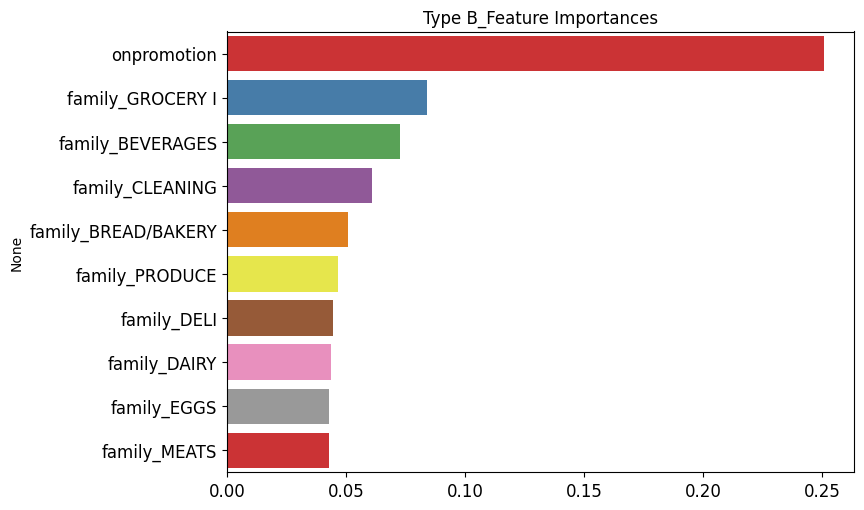

In [ ]:
visualize_ftr_importances(rf_tunedB, X_trainB)
plt.title("Type B_Feature Importances")
plt.show()

- `onpromotion`이 매출에 큰 영향을 미침
- 제품군의 종류 또한 모델의 예측 성능에 큰 영향을 미침

In [ ]:
### 모델 저장

import pickle
import joblib

joblib.dump(rf_tunedB, '/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/model/modelB.pkl')

### **4-3. 최종 예측**

#### **모델 불러오기**

In [39]:
import joblib

modelB = joblib.load('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/model/modelB.pkl')

#### **예측 수행**

In [40]:
predB = modelB.predict(X_testB)
predB = np.expm1(predB)
predB = np.round(predB, 2) # 소수 둘째자리에서 반올림

In [41]:
submissionB = pd.DataFrame({'id': testB['id'],
                      'sales': predB})
submissionB

,id,sales
0,3000954,5.77
1,3000955,1.20
2,3000956,5.37
3,3000957,3712.11
4,3000958,6.84
...,...,...
4219,3029395,350.25
4220,3029396,99.06
4221,3029397,1144.29
4222,3029398,76.91


#### **판매하지 않는 제품군 처리**
- 매출을 모두 0으로 처리

**전체**

In [42]:
zero_id_B = testB.loc[testB['family_BOOKS'] == 1, 'id']
submissionB.loc[submissionB['id'].isin(zero_id_B), 'sales'] = 0

In [43]:
submissionB

,id,sales
0,3000954,5.77
1,3000955,1.20
2,3000956,5.37
3,3000957,3712.11
4,3000958,0.00
...,...,...
4219,3029395,350.25
4220,3029396,99.06
4221,3029397,1144.29
4222,3029398,76.91


#### **순서 정렬**

In [44]:
submissionB = submissionB.sort_values(by='id')
submissionB

,id,sales
0,3000954,5.77
1,3000955,1.20
2,3000956,5.37
3,3000957,3712.11
4,3000958,0.00
...,...,...
4219,3029395,350.25
4220,3029396,99.06
4221,3029397,1144.29
4222,3029398,76.91


## **🏪 Type C**

In [45]:
trainC = train_types[2]
valC = val_types[2]
testC = test_types[2]

In [46]:
trainC.head()

,sales,onpromotion,dcoilwtico,store_nbr_10,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,4.242607,2.03505,-0.741523,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4.089617,-0.49963,1.656153,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,8.117611,-0.49963,1.182207,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6.511745,-0.49963,1.282294,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0.693147,-0.49963,1.576086,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
trainC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369996 entries, 0 to 369995
Data columns (total 98 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   sales                                 369996 non-null  float64
 1   onpromotion                           369996 non-null  float64
 2   dcoilwtico                            369996 non-null  float64
 3   store_nbr_10                          369996 non-null  int64  
 4   store_nbr_12                          369996 non-null  int64  
 5   store_nbr_13                          369996 non-null  int64  
 6   store_nbr_14                          369996 non-null  int64  
 7   store_nbr_15                          369996 non-null  int64  
 8   store_nbr_16                          369996 non-null  int64  
 9   store_nbr_17                          369996 non-null  int64  
 10  store_nbr_19                          369996 non-null  int64  
 11  

In [48]:
valC.head()

,sales,onpromotion,dcoilwtico,store_nbr_10,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,497.000000,-0.499630,1.325591,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,101.000000,1.671665,-0.640091,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,84.909996,2.356632,-0.612294,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,122.000000,-0.499630,-0.969219,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1.000000,-0.499630,-0.776254,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [49]:
testC.head()

,id,onpromotion,dcoilwtico,store_nbr_10,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,...,month_2,month_3,month_4,month_5,month_6,month_7,month_9,month_10,month_11,month_12
0,3000921,-0.499630,-0.70213,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3000922,-0.499630,-0.70213,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3000923,0.586017,-0.70213,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3000924,3.239902,-0.70213,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000925,-0.499630,-0.70213,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**데이터 준비**

In [50]:
## Feature vs Target

X_trainC = trainC.drop('sales', axis=1)
y_trainC = trainC['sales']

X_valC = valC.drop('sales', axis=1)
y_valC = valC['sales']

In [51]:
print(X_trainC.shape, y_trainC.shape)
print(X_valC.shape, y_valC.shape)

(369996, 97) (369996,)
(158571, 97) (158571,)


In [52]:
X_testC = testC.drop(['id', 'family_BOOKS'], axis = 1) # train 데이터에는 해당 정보가 x

In [53]:
X_testC = X_testC[X_trainC.columns] # 피처 순서 재조정

In [54]:
X_testC.shape

(7920, 97)

### **4-1. Base Model**

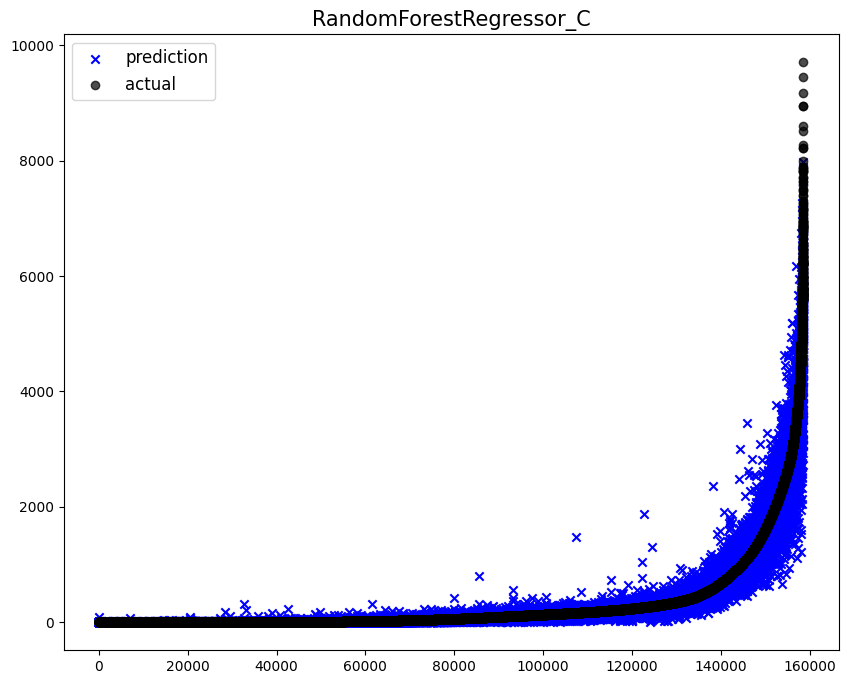

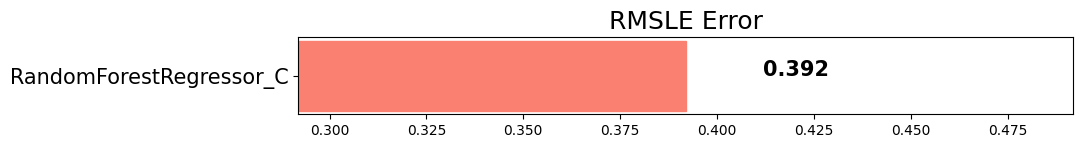


                            rmsle                    model
RandomForestRegressor_C  0.391982  RandomForestRegressor_C


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseC = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseC.fit(X_trainC, y_trainC)

# 모델 예측
rf_predC = rf_baseC.predict(X_valC)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predC = np.expm1(rf_predC)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_C', original_rf_predC, y_val)

### **4-2. 하이퍼 파라미터 튜닝**


In [ ]:
# !pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [ ]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)), # 트리 개수
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]), # 트리의 최대 깊이
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)), # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)), # 리프 노드를 위한 최소 샘플 수
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']) # 트리 분할 시 사용할 최대 특성의 수
}

In [ ]:
## 목적 함수 설정

def objective(params):
  model = RandomForestRegressor(**params)
  model.fit(X_trainC, y_trainC)

  y_pred = model.predict(X_valC)
  y_pred = np.expm1(y_pred) # 원래 스케일로 원복

  rmsle_val = rmsle(y_valC, y_pred)

  return {'loss': rmsle_val, 'status': STATUS_OK}

In [ ]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 30,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|██████████| 30/30 [3:30:51<00:00, 421.72s/trial, best loss: 0.378453555676789] 
{'max_depth': 0, 'max_features': 0, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 143}


- 하이퍼 파라미터 튜닝을 진행한 **model**의 성능이 더 좋다.

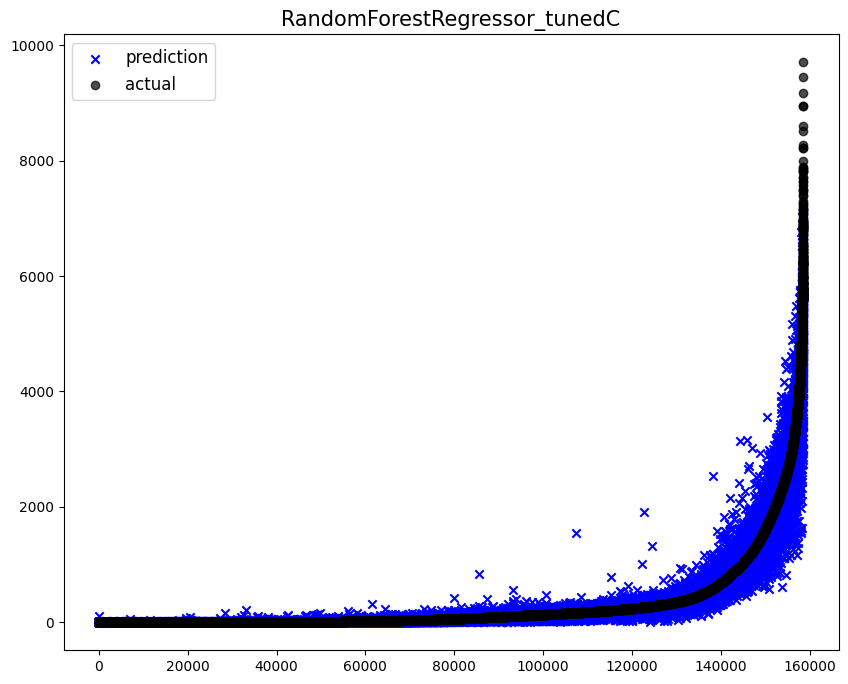

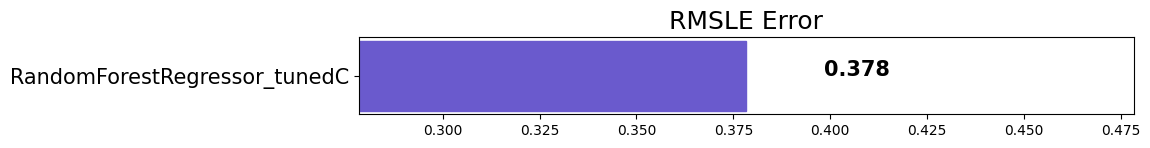


                                 rmsle                         model
RandomForestRegressor_tunedC  0.378396  RandomForestRegressor_tunedC


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedC = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 6,
                                  min_samples_split = 6, n_estimators = 143,
                                  n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedC.fit(X_trainC, y_trainC)

# 모델 예측
rf_predC = rf_tunedC.predict(X_valC)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predC = np.expm1(rf_predC)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedC', original_rf_predC, y_valC)

<ipython-input-11-d4b024794a90>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax, palette = 'Set1')


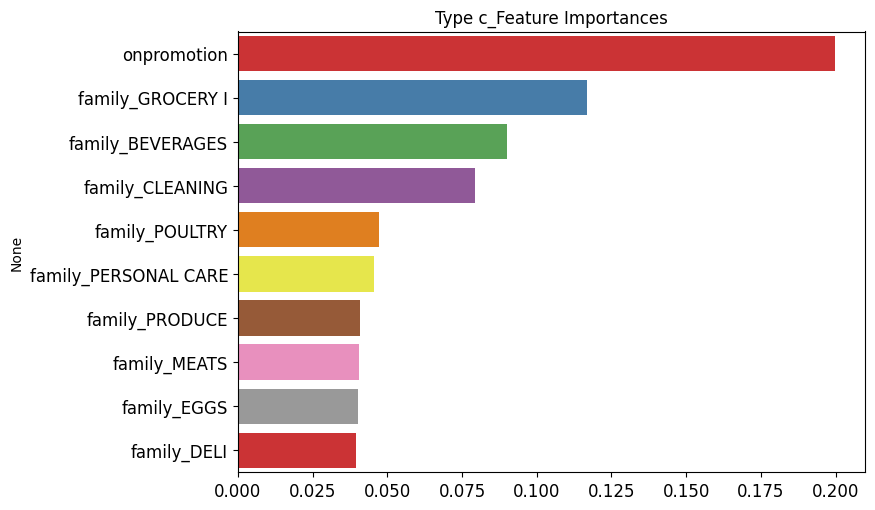

In [ ]:
visualize_ftr_importances(rf_tunedC, X_trainC)
plt.title("Type c_Feature Importances")
plt.show()

- `onpromotion`의 중요도가 크다.
- 제품군은 매출 예측에 중요한 역할을 한다.

In [ ]:
### 모델 저장

import pickle
import joblib

joblib.dump(rf_tunedC, '/content/drive/MyDrive/ESAA/OB/방학프로젝트/model/modelC.pkl')

['/content/drive/MyDrive/ESAA/OB/방학프로젝트/model/modelC.pkl']

### **4-3. 최종 예측**

#### **모델 불러오기**

In [55]:
import joblib

modelC = joblib.load('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/model/modelC.pkl')

#### **예측 수행**

In [56]:
predC = modelC.predict(X_testC)
predC = np.expm1(predC)
predC = np.round(predC, 2) # 소수 둘째자리에서 반올림

In [57]:
submissionC = pd.DataFrame({'id': testC['id'],
                      'sales': predC})
submissionC

,id,sales
0,3000921,1.92
1,3000922,1.34
2,3000923,2.89
3,3000924,1104.70
4,3000925,3.20
...,...,...
7915,3029263,52.49
7916,3029264,69.17
7917,3029265,437.82
7918,3029266,1.81


#### **판매하지 않는 제품군 처리**
- 매출을 모두 0으로 처리

**전체**

In [58]:
zero_id_C = testC.loc[testC['family_BOOKS'] == 1, 'id']
submissionC.loc[submissionC['id'].isin(zero_id_C), 'sales'] = 0

In [59]:
submissionC

,id,sales
0,3000921,1.92
1,3000922,1.34
2,3000923,2.89
3,3000924,1104.70
4,3000925,0.00
...,...,...
7915,3029263,52.49
7916,3029264,69.17
7917,3029265,437.82
7918,3029266,1.81


**store별**
- 13: BABY CARE
- 14, 30:LAWN AND GARDEN
- 16, 32, 33, 35, 40: LADIESWEAR
- 54: LADIESWEAR, LAWN AND GARDEN

In [60]:
zero_id_13 = testC.loc[(testC['store_nbr_13'] == 1)&(testC['family_BABY CARE'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_13), 'sales'] = 0

In [61]:
zero_id_14 = testC.loc[(testC['store_nbr_14'] == 1)&(testC['family_LAWN AND GARDEN'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_14), 'sales'] = 0

In [62]:
zero_id_16 = testC.loc[(testC['store_nbr_16'] == 1)&(testC['family_LADIESWEAR'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_16), 'sales'] = 0

In [63]:
zero_id_30 = testC.loc[(testC['store_nbr_30'] == 1)&(testC['family_LAWN AND GARDEN'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_30), 'sales'] = 0

In [64]:
zero_id_32 = testC.loc[(testC['store_nbr_32'] == 1)&(testC['family_LADIESWEAR'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_32), 'sales'] = 0

In [65]:
zero_id_33 = testC.loc[(testC['store_nbr_33'] == 1)&(testC['family_LADIESWEAR'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_33), 'sales'] = 0

In [66]:
zero_id_35 = testC.loc[(testC['store_nbr_35'] == 1)&(testC['family_LADIESWEAR'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_35), 'sales'] = 0

In [67]:
zero_id_40 = testC.loc[(testC['store_nbr_40'] == 1)&(testC['family_LADIESWEAR'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_40), 'sales'] = 0

In [68]:
zero_id_54 = testC.loc[(testC['store_nbr_54'] == 1)&(testC['family_LADIESWEAR'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_54), 'sales'] = 0

In [69]:
zero_id_54 = testC.loc[(testC['store_nbr_54'] == 1)&(testC['family_LAWN AND GARDEN'] == 1), 'id']
submissionC.loc[submissionC['id'].isin(zero_id_54), 'sales'] = 0

In [70]:
submissionC

,id,sales
0,3000921,1.92
1,3000922,1.34
2,3000923,2.89
3,3000924,1104.70
4,3000925,0.00
...,...,...
7915,3029263,52.49
7916,3029264,69.17
7917,3029265,437.82
7918,3029266,1.81


#### **순서 정렬**

In [71]:
submissionC = submissionC.sort_values(by='id')
submissionC

,id,sales
0,3000921,1.92
1,3000922,1.34
2,3000923,2.89
3,3000924,1104.70
4,3000925,0.00
...,...,...
7915,3029263,52.49
7916,3029264,69.17
7917,3029265,437.82
7918,3029266,1.81


## **🏪 Type D**

In [72]:
trainD = train_types[3]
valD = val_types[3]
testD = test_types[3]

In [73]:
trainD.head()

,sales,onpromotion,dcoilwtico,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,1.098612,0.550582,-0.772666,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,5.117077,-0.524798,-0.554732,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2.197225,-0.524798,-0.567332,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,5.375357,1.379962,-0.396456,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,3.806662,0.832181,-0.435203,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [74]:
trainD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509057 entries, 0 to 509056
Columns: 104 entries, sales to day_of_week_6
dtypes: float64(3), int64(101)
memory usage: 403.9 MB


In [75]:
valD.head()

,sales,onpromotion,dcoilwtico,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,302.000,-0.524798,1.198077,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,5.000,-0.524798,-0.612767,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,265.478,0.153691,-1.075015,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,301.000,1.229071,-0.417393,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,362.000,1.907560,-0.583546,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [76]:
testD.head()

,id,onpromotion,dcoilwtico,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,...,month_5,month_6,month_7,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_4
0,3000888,-0.524798,-0.68947,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3000889,-0.524798,-0.68947,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3000890,0.550582,-0.68947,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3000891,2.455342,-0.68947,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3000892,-0.524798,-0.68947,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**데이터 준비**

In [77]:
## Feature vs Target

X_trainD = trainD.drop('sales', axis=1)
y_trainD = trainD['sales']

X_valD = valD.drop('sales', axis=1)
y_valD = valD['sales']

In [78]:
print(X_trainD.shape, y_trainD.shape)
print(X_valD.shape, y_valD.shape)

(509057, 103) (509057,)
(218168, 103) (218168,)


In [79]:
X_testD = testD.drop(['id'], axis = 1)

In [80]:
X_testD = X_testD[X_trainD.columns]

In [81]:
X_testD.shape

(9504, 103)

### **4-1. Base Model**

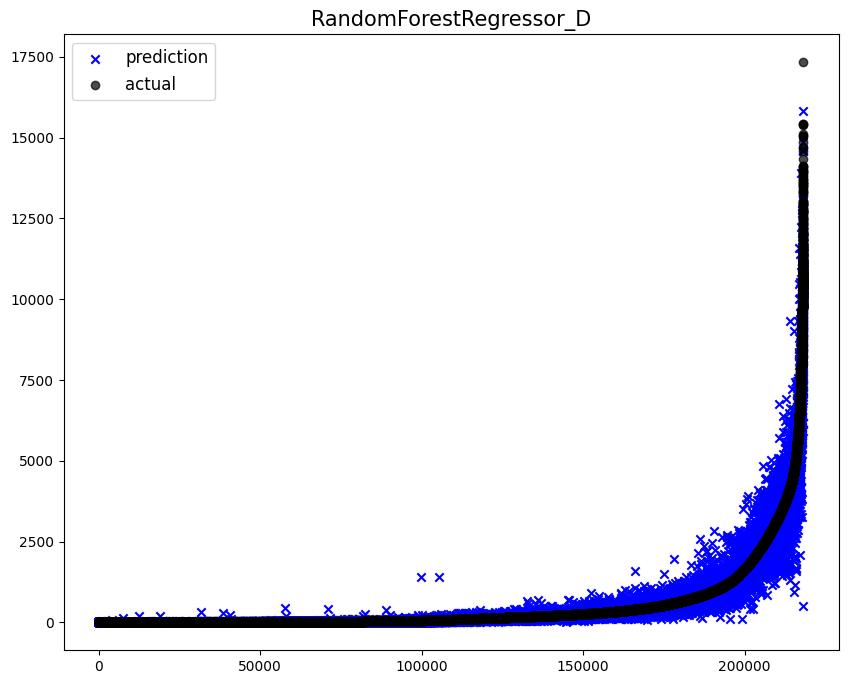

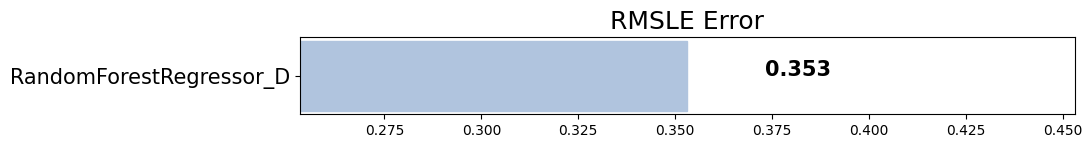


                            rmsle                    model
RandomForestRegressor_D  0.353195  RandomForestRegressor_D


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseD = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseD.fit(X_trainD, y_trainD)

# 모델 예측
rf_predD = rf_baseD.predict(X_valD)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predD = np.expm1(rf_predD)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_D', original_rf_predD, y_valD)

### **4-2. 하이퍼 파라미터 튜닝**


In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [ ]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)), # 트리 개수
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]), # 트리의 최대 깊이
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)), # 노드 분할을 위한 최소 샘플 수
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']) # 트리 분할 시 사용할 최대 특성의 수
}

In [ ]:
## 목적 함수 설정

def objective(params):
    model = RandomForestRegressor(**params)
    model.fit(X_trainD, y_trainD)

    y_pred = model.predict(X_valD)
    y_pred = np.expm1(y_pred) # 원래 스케일로 원복

    rmsle_val = rmsle(y_valD, y_pred)

    return {'loss': rmsle_val, 'status': STATUS_OK}

In [ ]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 20,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|██████████| 20/20 [2:35:30<00:00, 466.51s/trial, best loss: 0.35156679029764265]
{'max_depth': 0, 'max_features': 0, 'min_samples_split': 1, 'n_estimators': 46}


- 하이퍼 파라미터 튜닝을 진행한 **model**의 성능이 더 좋다.

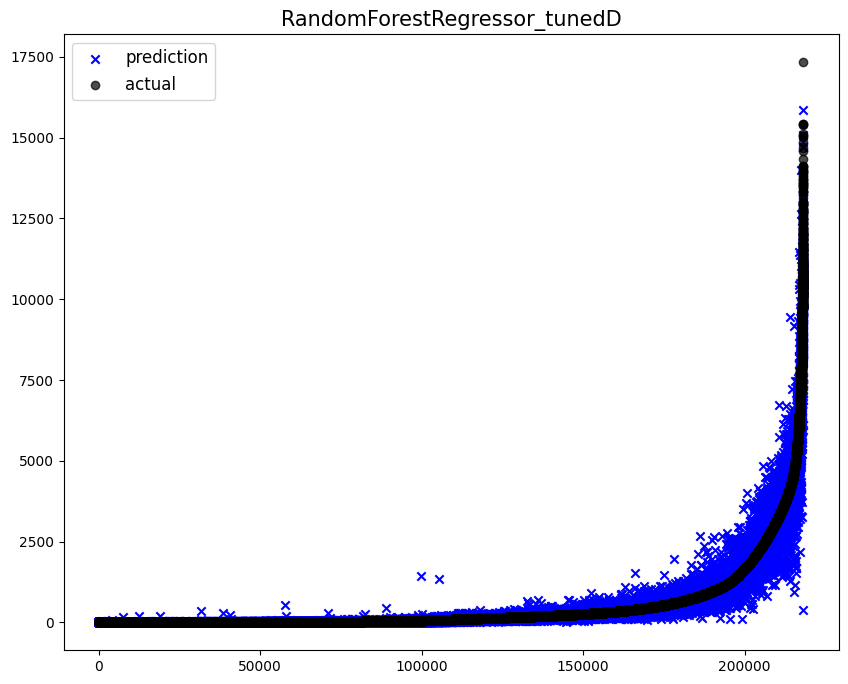

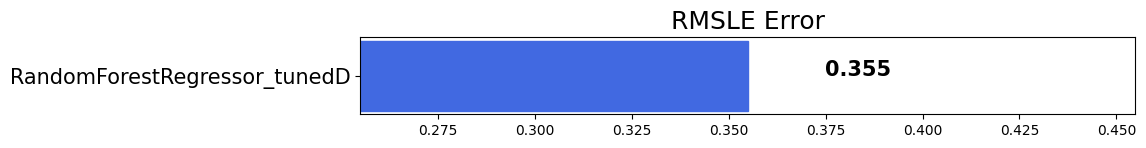


                                rmsle                         model
RandomForestRegressor_tunedD  0.35494  RandomForestRegressor_tunedD


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedD = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 1,
                                  n_estimators = 46, n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedD.fit(X_trainD, y_trainD)

# 모델 예측
rf_predD = rf_tunedD.predict(X_valD)

# 로그 스케일로 예측된 예측값을 원복
original_rf_predD = np.expm1(rf_predD)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedD', original_rf_predD, y_valD)

<ipython-input-11-d4b024794a90>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax, palette = 'Set1')


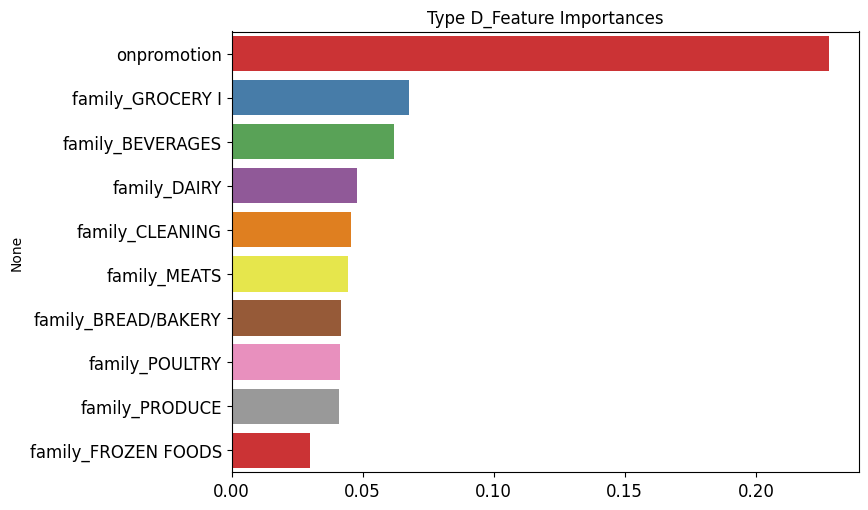

In [ ]:
visualize_ftr_importances(rf_tunedD, X_trainD)
plt.title("Type D_Feature Importances")
plt.show()

- `onpromotion`의 중요도가 크다.
- 제품군은 매출 예측에 중요한 역할을 한다.

In [ ]:
### 모델 저장

import pickle
import joblib

joblib.dump(rf_tunedD, '/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/방학프로젝트/model/modelD.pkl')

['/content/drive/MyDrive/Colab Notebooks/ESAA/OB/방학프로젝트/방학프로젝트/model/modelD.pkl']

### **4-3. 최종 예측**

#### **모델 불러오기**

In [82]:
import joblib

modelD = joblib.load('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/model/modelD.pkl')

#### **예측 수행**

In [83]:
predD = modelD.predict(X_testD)
predD = np.expm1(predD)
predD = np.round(predD, 2) # 소수 둘째자리에서 반올림

In [84]:
submissionD = pd.DataFrame({'id': testD['id'],
                      'sales': predD})
submissionD

,id,sales
0,3000888,3.71
1,3000889,1.43
2,3000890,6.12
3,3000891,2363.72
4,3000892,1.17
...,...,...
9499,3029362,419.13
9500,3029363,135.57
9501,3029364,3280.05
9502,3029365,1.28


#### **판매하지 않는 제품군 처리**
- 매출을 모두 0으로 처리

**store별**
- 1: BABY CARE
- 23: BABY CARE
- 25: LADIESWEAR


In [85]:
zero_id_1 = testD.loc[(testD['store_nbr_1'] == 1)&(testD['family_BABY CARE'] == 1), 'id']
submissionD.loc[submissionD['id'].isin(zero_id_1), 'sales'] = 0

In [86]:
zero_id_23 = testD.loc[(testD['store_nbr_23'] == 1)&(testD['family_BABY CARE'] == 1), 'id']
submissionD.loc[submissionD['id'].isin(zero_id_23), 'sales'] = 0

In [87]:
zero_id_25 = testD.loc[(testD['store_nbr_25'] == 1)&(testD['family_LADIESWEAR'] == 1), 'id']
submissionD.loc[submissionD['id'].isin(zero_id_25), 'sales'] = 0

In [88]:
submissionD

,id,sales
0,3000888,3.71
1,3000889,0.00
2,3000890,6.12
3,3000891,2363.72
4,3000892,1.17
...,...,...
9499,3029362,419.13
9500,3029363,135.57
9501,3029364,3280.05
9502,3029365,1.28


#### **순서 정렬**

In [89]:
submissionD = submissionD.sort_values(by='id')
submissionD

,id,sales
0,3000888,3.71
1,3000889,0.00
2,3000890,6.12
3,3000891,2363.72
4,3000892,1.17
...,...,...
9499,3029362,419.13
9500,3029363,135.57
9501,3029364,3280.05
9502,3029365,1.28


## **🏪 Type E**

In [90]:
trainE = train_types[4]
valE = val_types[4]
testE = test_types[4]

In [91]:
trainE.head()

,sales,onpromotion,type,dcoilwtico,store_nbr_28,store_nbr_29,store_nbr_36,store_nbr_43,family_AUTOMOTIVE,family_BABY CARE,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,8.010692,0.450022,E,-0.797044,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.302585,-0.540343,E,-0.495908,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3.295837,-0.540343,E,-0.476580,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0.693147,-0.540343,E,1.903392,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.713572,-0.540343,E,-0.140047,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [92]:
valE.head()

,sales,onpromotion,type,dcoilwtico,store_nbr_28,store_nbr_29,store_nbr_36,store_nbr_43,family_AUTOMOTIVE,family_BABY CARE,...,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,7.796336,1.699722,E,-0.913943,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.693147,-0.540343,E,1.643957,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4.776751,-0.540343,E,-0.673666,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,5.669881,-0.540343,E,1.280050,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,8.360305,0.084507,E,-0.622227,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [93]:
testE.head()

,id,onpromotion,type,dcoilwtico,store_nbr_28,store_nbr_29,store_nbr_36,store_nbr_43,family_AUTOMOTIVE,family_BABY CARE,...,month_6,month_7,month_9,quarter_1,quarter_2,quarter_4,year_2013,year_2014,year_2015,year_2016
0,3001548,-0.540343,E,-0.601119,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3001549,-0.540343,E,-0.601119,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3001550,0.450022,E,-0.601119,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3001551,2.949423,E,-0.601119,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3001552,-0.540343,E,-0.601119,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
trainE.drop('type',inplace=True,axis=1)
valE.drop('type',inplace=True,axis=1)
testE.drop('type',inplace=True,axis=1)

In [95]:
trainE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94833 entries, 0 to 94832
Data columns (total 71 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   sales                              94833 non-null  float64
 1   onpromotion                        94833 non-null  float64
 2   dcoilwtico                         94833 non-null  float64
 3   store_nbr_28                       94833 non-null  int64  
 4   store_nbr_29                       94833 non-null  int64  
 5   store_nbr_36                       94833 non-null  int64  
 6   store_nbr_43                       94833 non-null  int64  
 7   family_AUTOMOTIVE                  94833 non-null  int64  
 8   family_BABY CARE                   94833 non-null  int64  
 9   family_BEAUTY                      94833 non-null  int64  
 10  family_BEVERAGES                   94833 non-null  int64  
 11  family_BREAD/BAKERY                94833 non-null  int

**데이터 준비**

In [96]:
## Feature vs Target

X_trainE = trainE.drop('sales', axis=1)
y_trainE = trainE['sales']

X_valE = valE.drop('sales', axis=1)
y_valE = valE['sales']

In [97]:
print(X_trainE.shape, y_trainE.shape)
print(X_valE.shape, y_valE.shape)

(94833, 70) (94833,)
(40643, 70) (40643,)


In [98]:
X_testE = testE.drop(['id', 'family_BOOKS'], axis = 1) # train에는 해당 정보가 x

In [99]:
X_testE = X_testE[X_trainE.columns] # 피처 순서 재조정

In [100]:
X_testE.shape

(2112, 70)

### **4-1. Base Model**

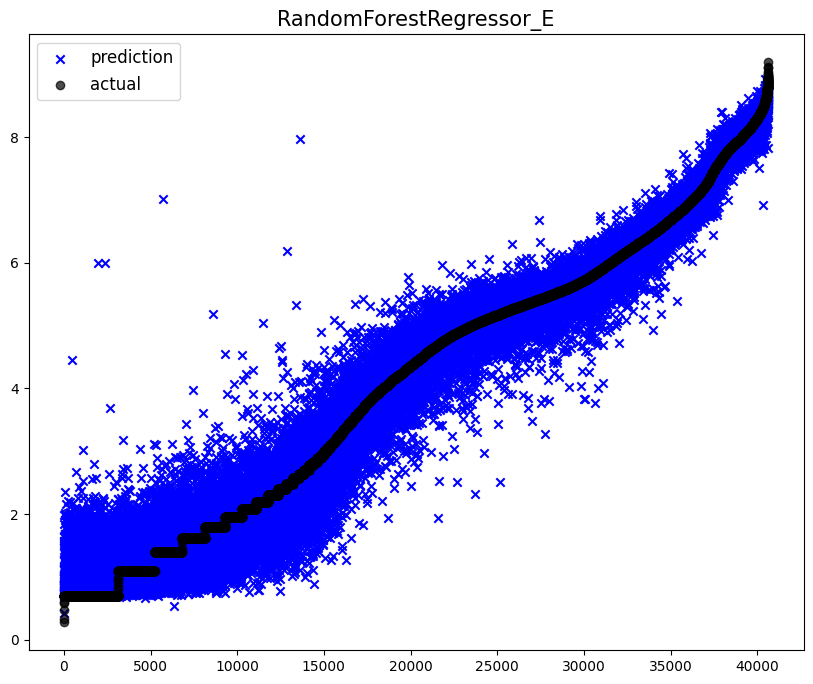

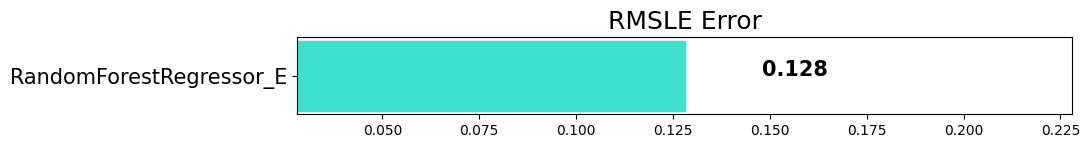


                            rmsle                    model
RandomForestRegressor_E  0.128004  RandomForestRegressor_E


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_baseE = RandomForestRegressor(n_jobs = -1, random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_baseE.fit(X_trainE, y_trainE)

# 모델 예측
rf_predE = rf_baseE.predict(X_valE)

# 로그 스케일로 예측된 예측값을 원복
# original_rf_predE = np.expm1(rf_predE)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_E', rf_predE, y_valE)

### **4-2. 하이퍼 파라미터 튜닝**

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import STATUS_OK

In [ ]:
## 검색 공간 설정

space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201)),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30]),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']),
}

In [ ]:
## 목적 함수 설정

def objective(params):
  model = RandomForestRegressor(**params)
  model.fit(X_trainE, y_trainE)

  y_pred = model.predict(X_valE)
  #y_pred = np.expm1(y_pred) # 원래 스케일로 원복

  rmsle_val = rmsle(y_valE, y_pred)

  return {'loss': rmsle_val, 'status': STATUS_OK}

In [ ]:
## 파라미터 최적화 수행

trials = Trials()
best = fmin(fn = objective, # 목적 함수
            space = space, # 탐색 공간
            algo = tpe.suggest, # 최적화 적용 알고리즘
            max_evals = 30,  # 최대 반복 횟수
            trials = trials, # 최적값 반환
            rstate = np.random.default_rng(seed = 0)) # seed 설정
print(best)

100%|██████████| 30/30 [33:51<00:00, 67.72s/trial, best loss: 0.12369123837042242] 
{'max_depth': 0, 'max_features': 0, 'min_samples_leaf': 8, 'min_samples_split': 0, 'n_estimators': 143}


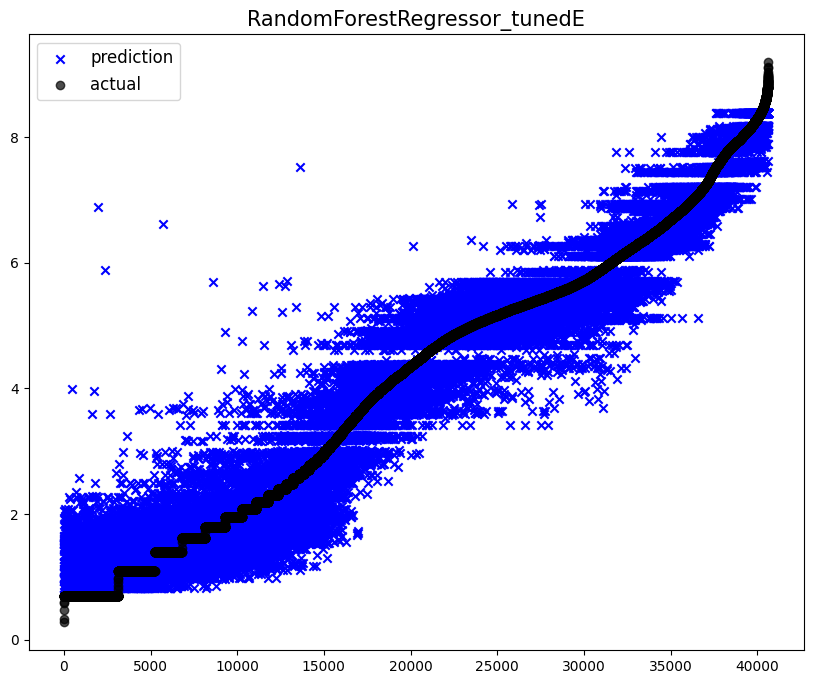

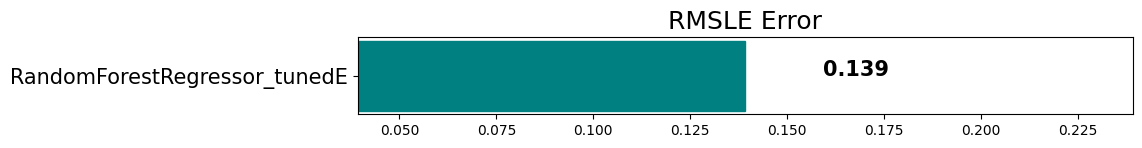


                                 rmsle                         model
RandomForestRegressor_tunedE  0.139192  RandomForestRegressor_tunedE


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 최적 모델 생성
rf_tunedE = RandomForestRegressor(max_depth = None, max_features = None, min_samples_leaf = 8,
                                  min_samples_split = 0.01, n_estimators = 143, n_jobs = -1,random_state = 42)

my_predictions = {}  # 결과를 저장할 딕셔너리

# 모델 학습
rf_tunedE.fit(X_trainE, y_trainE)

# 모델 예측
rf_predE = rf_tunedE.predict(X_valE)

# 로그 스케일로 예측된 예측값을 원복
#original_rf_predE = np.expm1(rf_predE)

# 모델 평가 및 시각화
model_eval('RandomForestRegressor_tunedE', rf_predE, y_valE)

<ipython-input-64-33f300f93aba>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top10.values, y=ftr_top10.index, ax=ax, palette = 'Set1')


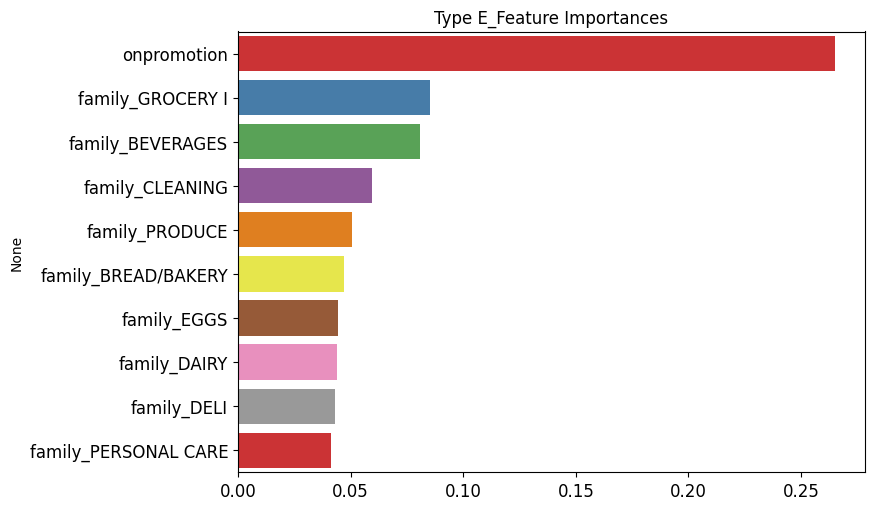

In [ ]:
visualize_ftr_importances(rf_tunedE)
plt.title("Type E_Feature Importances")
plt.show()

### **4-3. 최종 예측**

#### **모델 불러오기**

In [101]:
import joblib

modelE = joblib.load('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/model/modelE.pkl')

#### **예측 수행**

In [102]:
predE = modelE.predict(X_testE)
predE = np.expm1(predE)
predE = np.round(predE, 2) # 소수 둘째자리에서 반올림

In [103]:
submissionE = pd.DataFrame({'id': testE['id'],
                      'sales': predE})
submissionE

,id,sales
0,3001548,5.14
1,3001549,1.34
2,3001550,6.22
3,3001551,2534.87
4,3001552,4.15
...,...,...
2107,3028867,164.43
2108,3028868,58.73
2109,3028869,959.24
2110,3028870,2.22


#### **판매하지 않는 제품군 처리**
- 매출을 모두 0으로 처리

**전체**

In [104]:
zero_id_E = testE.loc[testE['family_BOOKS'] == 1, 'id']
submissionE.loc[submissionE['id'].isin(zero_id_E), 'sales'] = 0

In [105]:
submissionE

,id,sales
0,3001548,5.14
1,3001549,1.34
2,3001550,6.22
3,3001551,2534.87
4,3001552,0.00
...,...,...
2107,3028867,164.43
2108,3028868,58.73
2109,3028869,959.24
2110,3028870,2.22


**store별**
- 28: LADIESWEAR
- 29: LADIESWEAR
- 43: LADIESWEAR


In [106]:
zero_id_28 = testE.loc[(testE['store_nbr_28'] == 1)&(testE['family_LADIESWEAR'] == 1), 'id']
submissionE.loc[submissionE['id'].isin(zero_id_28), 'sales'] = 0

In [107]:
zero_id_29 = testE.loc[(testE['store_nbr_29'] == 1)&(testE['family_LADIESWEAR'] == 1), 'id']
submissionE.loc[submissionE['id'].isin(zero_id_29), 'sales'] = 0

In [108]:
zero_id_43 = testE.loc[(testE['store_nbr_43'] == 1)&(testE['family_LADIESWEAR'] == 1), 'id']
submissionE.loc[submissionE['id'].isin(zero_id_43), 'sales'] = 0

In [109]:
submissionE

,id,sales
0,3001548,5.14
1,3001549,1.34
2,3001550,6.22
3,3001551,2534.87
4,3001552,0.00
...,...,...
2107,3028867,164.43
2108,3028868,58.73
2109,3028869,959.24
2110,3028870,2.22


#### **순서 정렬**

In [110]:
submissionE = submissionE.sort_values(by='id')
submissionE

,id,sales
0,3001548,5.14
1,3001549,1.34
2,3001550,6.22
3,3001551,2534.87
4,3001552,0.00
...,...,...
2107,3028867,164.43
2108,3028868,58.73
2109,3028869,959.24
2110,3028870,2.22


# **5. submission 파일 작성**

In [111]:
sample_submission = pd.read_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/data/sample_submission.csv')
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [114]:
submission = pd.concat([submissionA, submissionB], axis = 0)
submission = pd.concat([submission, submissionC], axis = 0)
submission = pd.concat([submission, submissionD], axis = 0)
submission = pd.concat([submission, submissionE], axis = 0)

In [115]:
### 순서 정렬

submission = submission.sort_values(by='id')
submission

,id,sales
0,3000888,3.71
1,3000889,0.00
2,3000890,6.12
3,3000891,2363.72
4,3000892,1.17
...,...,...
4219,3029395,350.25
4220,3029396,99.06
4221,3029397,1144.29
4222,3029398,76.91


In [117]:
submission.to_csv('/content/drive/MyDrive/ESAA 8기/OB/winter_proj/방학프로젝트/submission.csv', index = False)